In [1]:
!pip install pandas matplotlib yfinance xgboost

  Using cached xgboost-2.1.4-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 578.7 kB/s eta 0:03:35
   ---------------------------------------- 0.5/124.9 MB 578.7 kB/s eta 0:03:35
   ---------------------------------------- 0.8/124.9 MB 671.3 kB/s eta 0:03:05
   ---------------------------------------- 1.0/124.9 MB 774.8 kB/s eta 0:02:40
   ---------------------------------------- 1.3/124.9 MB 838.9 kB/s eta 0:02:28
    --------------------------------------- 1.6/124.9 MB 883.2 kB/s eta 0:02:20
    --------------------------------------- 1.6/124.9 MB 883.2 kB/s eta 0:02:20
    -----------


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [3]:
# Define kode saham dan rentang waktu (1 tahun cukup)
stock_symbol = 'FTT-USD'
start_date = '2022-11-14'
end_date = '2023-11-14'

In [4]:
# Ambil bagian historical data
df = yf.download(stock_symbol, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
# Pilih kolom 'Open' (butuhnya opening price)
ts = df['Open'].values

In [6]:
print(ts)

[[1.49011004]
 [1.47427404]
 [1.83462596]
 [1.62528396]
 [1.56169605]
 [1.45689595]
 [1.41655099]
 [1.331622  ]
 [1.25741601]
 [1.33343196]
 [1.29859698]
 [1.37550104]
 [1.40119505]
 [1.36450601]
 [1.31575096]
 [1.29403603]
 [1.30423903]
 [1.34015799]
 [1.29195297]
 [1.30669999]
 [1.31465304]
 [1.38741302]
 [1.39137304]
 [1.45479798]
 [1.39118099]
 [1.36426103]
 [1.700912  ]
 [1.51605797]
 [1.52172601]
 [1.48479998]
 [1.40507495]
 [1.374439  ]
 [1.35659301]
 [1.14310801]
 [1.07892501]
 [1.04088998]
 [0.96074402]
 [0.93813401]
 [0.87397301]
 [1.02713299]
 [0.95750499]
 [0.92443198]
 [0.89456701]
 [0.93113798]
 [0.92116201]
 [0.88572299]
 [0.86019301]
 [0.83896798]
 [0.84297401]
 [0.85811198]
 [0.86230701]
 [0.88518697]
 [1.00226498]
 [0.94411999]
 [0.91083902]
 [0.90921497]
 [0.91302401]
 [1.32805502]
 [1.24062502]
 [1.30208302]
 [1.37791204]
 [1.40603006]
 [1.84186304]
 [2.20495892]
 [2.51167893]
 [2.0784719 ]
 [1.76817   ]
 [2.29456091]
 [2.40961194]
 [2.16448212]
 [2.1053431 ]
 [2.19

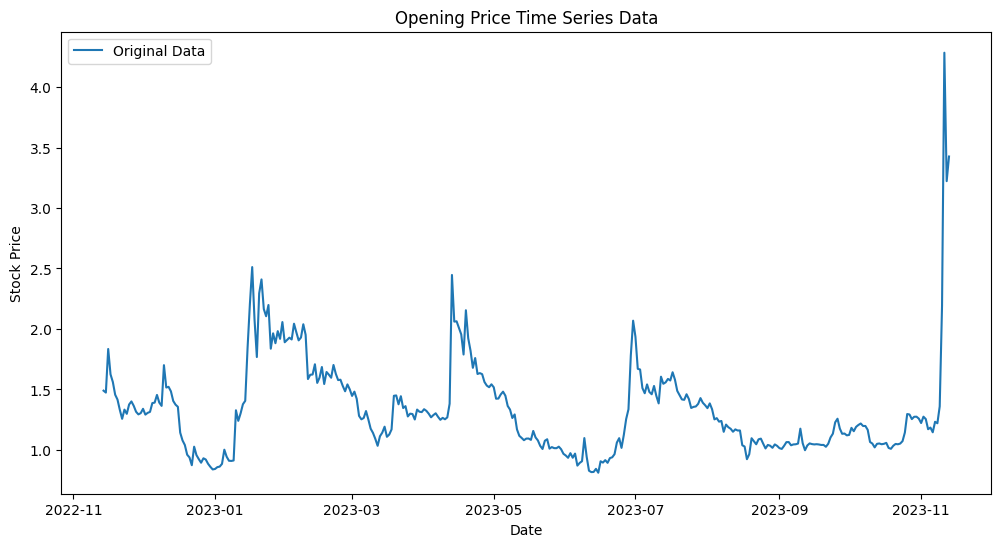

In [7]:
# Display time series plot dari original data opening price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label='Original Data')
plt.title('Opening Price Time Series Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
# Normalisasi data
scaler = StandardScaler()
ts = scaler.fit_transform(np.array(ts).reshape(-1, 1))

In [9]:
# Prepare X_train dan X_test
seq_length = 30

X_train = []
y_train = []

for i in range(len(ts) - seq_length):
    X_train.append(ts[i:i + seq_length])
    y_train.append(ts[i + seq_length])

In [10]:
# Memastikan X_train dan y_train adalah numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [11]:
# Split data menjadi training dan testing (80% training, 20% testing)
train_size = int(len(X_train) * 0.8)
X_train, X_test = X_train[:train_size], X_train[train_size:]
y_train, y_test = y_train[:train_size], y_train[train_size:]

In [12]:
# Model Architecture
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))  # tambah dropout buat prevent overfitting
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Training Parameters
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early stopping callback

In [14]:
# Model Training
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.9669 - val_loss: 0.2856
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7063 - val_loss: 0.0977
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5650 - val_loss: 0.0554
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5095 - val_loss: 0.1108
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5546 - val_loss: 0.1190
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4362 - val_loss: 0.0393
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.0439
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2581 - val_loss: 0.0580
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2589 - val_loss: 0.0261
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3061 - val_loss: 0.0295
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2725 - val_loss: 0.0423
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2520 - val_loss: 0.0317
E

In [15]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [16]:
# Menghitung RMSE dan MAE
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [17]:
# Data Augmentation (di sini pakai Random Noise)
# tambah random noise ke training data
noise = np.random.normal(0, 0.1, X_train.shape)
X_train_noisy = X_train + noise
model.fit(X_train_noisy, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2574 - val_loss: 0.0363
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1831 - val_loss: 0.0302
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1562 - val_loss: 0.0397
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2258 - val_loss: 0.0270
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2331 - val_loss: 0.0313
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1523 - val_loss: 0.0334
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1888 - val_loss: 0.0268
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1701 - val_loss: 0.0340
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1646 - val_loss: 0.0541
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2666 - val_loss: 0.0481


In [18]:
# Feature Engineering (di sini pake Adding Volume Data, untuk menambahkan informasi lebih ke analisis time series)
df['Volume'] = df['Volume'] / 1e7
additional_features = df['Volume'].values

In [19]:
# Concatenate additional features with X_train
additional_features = additional_features.reshape(-1, 1, 1)
additional_features = additional_features[-len(X_train):]
X_train = np.concatenate((X_train, additional_features), axis=1)


In [20]:
# Ensemble Methods
X_train_2d = X_train.reshape(X_train.shape[0], -1)
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train_2d, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
from tensorflow.keras.regularizers import l2

# Regularization (L2 Regularization)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Menerapkan k-fold cross-validation (buat improve performance dari modelnya)
tscv = TimeSeriesSplit(n_splits=5)
rmses = []
maes = []

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index, :seq_length], X_train[test_index, :seq_length]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Define dan train neural network model
    model = keras.Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, batch_size=32, callbacks=[early_stopping])

    # Evaluasi model
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)

    rmse = sqrt(mean_squared_error(y_val_fold, model.predict(X_val_fold)))
    mae = mean_absolute_error(y_val_fold, model.predict(X_val_fold))

    rmses.append(rmse)
    maes.append(mae)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 1.9091 - val_loss: 0.7694
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6283 - val_loss: 0.6875
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.6932 - val_loss: 0.5529
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.5488 - val_loss: 0.3393
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.4420 - val_loss: 0.4742
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9643 - val_loss: 3.2006
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8949 - val_loss: 0.1394
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8226 - val_loss: 0.1118
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5352 - val_loss: 0.2058
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.4548 - val_loss: 0.3623
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7175 - val_loss: 0.3529
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3505 - val_loss: 0.2608


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 1.4632 - val_loss: 0.7381
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1494 - val_loss: 0.6270
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.1230 - val_loss: 0.6279
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8454 - val_loss: 0.6470
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8920 - val_loss: 0.6303
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8568 - val_loss: 0.6316
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5909 - val_loss: 0.6796
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7442 - val_loss: 0.6826
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.8071 - val_loss: 0.6552
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6747 - val_loss: 0.6190
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6711 - val_loss: 0.6035
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6422 - val_loss: 0.6056
Epoch 13/50

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 1.0821 - val_loss: 0.6122
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0076 - val_loss: 1.0923
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8361 - val_loss: 0.6634
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8104 - val_loss: 0.6000
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.8519 - val_loss: 0.3387
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8252 - val_loss: 0.4067
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8806 - val_loss: 0.5176
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6943 - val_loss: 0.7576
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6621 - val_loss: 0.6219
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7056 - val_loss: 0.5173
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6552 - val_loss: 0.4630
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5987 - val_loss: 0.4404
Epoch 13/50


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.9331 - val_loss: 0.5558
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7414 - val_loss: 0.4233
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6370 - val_loss: 1.2073
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5460 - val_loss: 0.4511
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6834 - val_loss: 0.4409
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6126 - val_loss: 0.3871
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5767 - val_loss: 0.3535
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5461 - val_loss: 0.3283
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4125 - val_loss: 0.7807
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3522 - val_loss: 0.2607
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3099 - val_loss: 0.4805
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2430 - val_loss: 0.5706
Epoch 13/50


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.8288 - val_loss: 0.3816
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7557 - val_loss: 0.2557
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6142 - val_loss: 0.1056
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5638 - val_loss: 0.1529
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6412 - val_loss: 0.2048
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6210 - val_loss: 0.2317
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6112 - val_loss: 0.1209
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5221 - val_loss: 0.0619
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3308 - val_loss: 0.0362
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2764 - val_loss: 0.0298
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2904 - val_loss: 0.0303
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4117 - val_loss: 0.0444
Epoch 13/50


In [23]:
# Menghitung average RMSE dari cross-validation
mean_rmse = np.mean(rmses)
mean_mae = np.mean(maes)
print(f"Average RMSE: {mean_rmse}")
print(f"Average MAE: {mean_mae}")

Average RMSE: 0.3642240667715957
Average MAE: 0.26010259515104045


In [24]:
# Predictions untuk test data (X_test)
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [47]:
model.save('timeseries_model.h5')

In [25]:
print(y_pred_test)

[[1.0932556]
 [1.1055506]
 [1.1175402]
 [1.141568 ]
 [1.1641866]
 [1.1760479]
 [1.1797838]
 [1.1797578]
 [1.1730059]
 [1.1651721]
 [1.1538769]
 [1.1453404]
 [1.1421738]
 [1.1383427]
 [1.1328061]
 [1.1305342]
 [1.1356658]
 [1.1491104]
 [1.1803929]
 [1.2303456]
 [1.2788528]
 [1.3128097]
 [1.3324338]
 [1.3369068]
 [1.329769 ]
 [1.3209183]
 [1.3114088]
 [1.3053765]
 [1.303753 ]
 [1.3060987]
 [1.3094823]
 [1.31173  ]
 [1.3091682]
 [1.2964417]
 [1.267461 ]
 [1.2260993]
 [1.1830411]
 [1.1453711]
 [1.1147308]
 [1.0900958]
 [1.0704129]
 [1.0542988]
 [1.040342 ]
 [1.029093 ]
 [1.0214745]
 [1.0178514]
 [1.018394 ]
 [1.0238001]
 [1.0415127]
 [1.0824664]
 [1.1458547]
 [1.2228947]
 [1.2960851]
 [1.3569494]
 [1.402056 ]
 [1.4297588]
 [1.4438142]
 [1.4479321]
 [1.4371862]
 [1.4157227]
 [1.3835963]
 [1.3536826]
 [1.327354 ]
 [1.3169472]
 [1.3793265]
 [1.5814772]
 [1.8106593]]


In [26]:
# RMSE dan MAE dari test data
rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE for Test Data: {rmse_test}")
print(f"MAE for Test Data: {mae_test}")

RMSE for Test Data: 1.9421021547370914
MAE for Test Data: 1.8332280952268971


In [27]:
# forecasting
forecast_days = 5
X_forecast = np.copy(X_test[-1])

forecasted_values = []

for _ in range(forecast_days):
    forecasted_value = model.predict(X_forecast.reshape(1, seq_length, 1))
    forecasted_values.append(forecasted_value[0, 0])

    X_forecast = np.roll(X_forecast, -1)
    X_forecast[-1] = forecasted_value

forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [28]:
print(forecasted_values)

[[1.8106593]
 [1.9954684]
 [2.1313818]
 [2.2240283]
 [2.2860994]]


In [29]:
# date range buat forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_days + 1)[1:]

# date range buat test data
test_dates = df.index[-len(y_pred_test):]

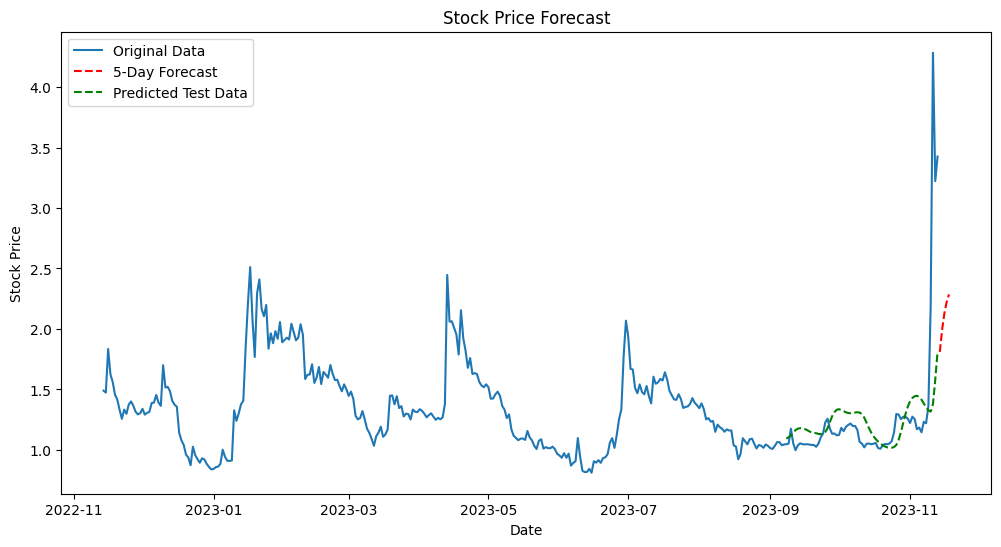

In [30]:
# Plot dari original data, predicted test data, dan forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label='Original Data')
plt.plot(forecast_dates, forecasted_values, label='5-Day Forecast', linestyle='--', color='red')
plt.plot(test_dates, y_pred_test, label='Predicted Test Data', linestyle='--', color='green') # Adding the predicted test data
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

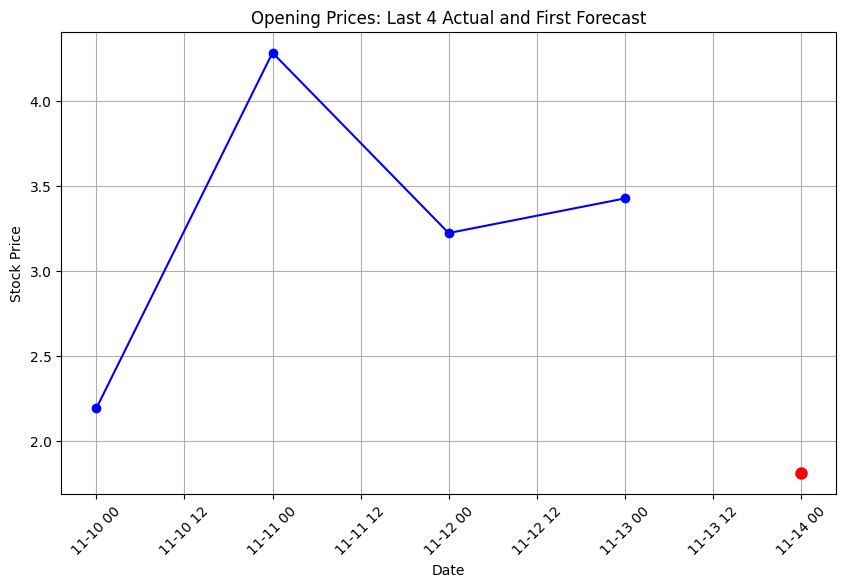

In [44]:
# Extract the last 4 actual opening prices and the first forecast opening price
last_4_actual_opening_prices = df['Open'][-4:]  # Last 4 actual opening prices
first_forecast_opening_price = forecasted_values[0][0]  # First forecast opening price

# Concatenate the last 4 actual opening prices and the first forecast opening price
plot_data = pd.concat([last_4_actual_opening_prices, pd.Series([first_forecast_opening_price], index=[forecast_dates[0]])])

# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(plot_data.index, plot_data.values, marker='o', linestyle='-', color='blue')  # Blue line and dots

# Highlight the last point in red
plt.plot([plot_data.index[-1]], [plot_data.values[-1]], marker='o', markersize=8, linestyle='--', color='red')

plt.title('Opening Prices: Last 4 Actual and First Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [38]:
# Calculate the difference in the opening stock price between the last day of the actual data and the first day of the forecast
last_actual_day = df.index[-1]  # Last day of the actual data
first_forecast_day = forecast_dates[0] # First day of the forecast

last_actual_opening_price = df['Open'].iloc[-1]    # Opening price of the last day in the actual data
first_forecast_opening_price = forecasted_values[0][0]  # Opening price of the first day in the forecast

price_difference = first_forecast_opening_price - last_actual_opening_price
percentage_change = price_difference/last_actual_opening_price

print(f"last actual opening price: {last_actual_day} = {last_actual_opening_price}")
print(f"first forecast opening price: {first_forecast_day} = {first_forecast_opening_price}")
print(f"Difference in opening stock price between last actual day and first forecast day: {price_difference}")
print(f"Percentage Change: {percentage_change}")

last actual opening price: 2023-11-13 00:00:00 = Ticker
FTT-USD    3.425437
Name: 2023-11-13 00:00:00, dtype: float64
first forecast opening price: 2023-11-14 00:00:00 = 1.8106592893600464
Difference in opening stock price between last actual day and first forecast day: Ticker
FTT-USD   -1.614778
Name: 2023-11-13 00:00:00, dtype: float64
Percentage Change: Ticker
FTT-USD   -0.471408
Name: 2023-11-13 00:00:00, dtype: float64


In [45]:
# adjusted percentage_change to be weighted metric
weighted_metric = (percentage_change + 1) / 2

print(f"weighted metric: {weighted_metric}")

weighted metric: Ticker
FTT-USD    0.264296
Name: 2023-11-13 00:00:00, dtype: float64


In [46]:
# Calculate R-squared score
r_squared = r2_score(y_test, y_pred_test)
print(f"R-squared Score: {r_squared}")

R-squared Score: -0.9326034950793092
